# Figures for Yeager et al., 2025: Efficient Drift Correction of Initialized Earth System Predictions
### CESM2-SMYLE and E3SMv2.1-SMYLE analysis

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xesmf as xe
import os
import nc_time_axis
%matplotlib inline

# import plotting and other utilities 
# https://github.com/sgyeager/mypyutils
from mypyutils import calendar_utils as cal
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import regrid_utils as regrid
from mypyutils import io_utils as io
from mypyutils import stat_utils as stat

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2025.4.1'

## Preprocessing:  Data I/O using Dask

### Create Dask Cluster

In [94]:
try:
    client.shutdown()
except:
    pass

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='32GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=32GB',
        account='P06010014',
        walltime='02:30:00',
        local_directory='/glade/derecho/scratch/yeager/',
        log_directory='/glade/derecho/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": 1.0,
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(50) 
client

<Client: 'tcp://128.117.208.179:44105' processes=0 threads=0, memory=0 B>

### Read in CESM2-SMYLE TS monthly data

In [32]:
datadir = '/glade/derecho/scratch/yeager/YeagerEA_EffDriftCorr/data/'

In [33]:
cesm_smyle11 = xr.open_dataset(datadir+'CESM2-SMYLE_NOV.TS.1970-2020.nc').chunk({'M':1})
cesm_smyle11['TS'] = cesm_smyle11['TS'].astype('float32')

In [34]:
cesm_smyle11_climoic = xr.open_dataset(datadir+'CESM2-SMYLE_NOV.TS.climoIC.nc').chunk({'M':1})
cesm_smyle11_climoic['TS'] = cesm_smyle11_climoic['TS'].astype('float32')

### Read in E3SM2-SMYLE TS monthly data

In [35]:
e3sm_smyle11 = xr.open_dataset(datadir+'E3SMv2.1-SMYLE_NOV.TS.1970-2020.nc').chunk({'M':1})
e3sm_smyle11['TS'] = e3sm_smyle11['TS'].astype('float32')

In [36]:
e3sm_smyle11_climoic = xr.open_dataset(datadir+'E3SMv2.1-SMYLE_NOV.TS.climoIC.nc').chunk({'M':1})
e3sm_smyle11_climoic['TS'] = e3sm_smyle11_climoic['TS'].astype('float32')

### Observed merged TS

In [37]:
cruhad = xr.open_dataset(datadir+'merged_CRU-TS4.05_HadISST.TS.1960-2020.fv09.nc').astype('float32')

## Obs monthly anomalies

In [19]:
climy0 = 1991
climy1 = 2020

In [20]:
def monthly_anomaly(da, y0, y1, output='anomaly', groupby_type="time.month"):
    gb = da.groupby(groupby_type)
    clim = da.sel(time=slice(str(y0),str(y1))).groupby(groupby_type).mean(dim="time")
    anom = gb - clim
    if output=='anomaly':
        da_out = anom
    else:
        da_out = clim
    return da_out

In [21]:
%%time
obs_mon_clim = monthly_anomaly(cruhad,climy0,climy1,'clim').compute()
obs_mon_anom = cruhad.map_blocks(monthly_anomaly, args=[climy0,climy1,'anomaly'], template=cruhad).compute()

CPU times: user 176 ms, sys: 64.2 ms, total: 240 ms
Wall time: 652 ms


### De-drift (using various methods)

In [38]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1991
climy1 = 2020
cesm_smyle11_time = cesm_smyle11.time.load()
cesm_smyle11_anom_meth2,cesm_smyle11_clim = stat.remove_drift(cesm_smyle11['TS'],cesm_smyle11_time,climy0,climy1)

CPU times: user 20.7 ms, sys: 8.19 ms, total: 28.9 ms
Wall time: 77.8 ms


In [39]:
%%time
# Method 2, but only 1 member
iterations = 100
cesm_smyle11_anom_meth2_1mem,cesm_smyle11_clim_1mem = stat.remove_drift_nmem(cesm_smyle11['TS'].drop_vars('M'),cesm_smyle11_time,climy0,climy1,1,iterations)

CPU times: user 6.92 s, sys: 85.5 ms, total: 7.01 s
Wall time: 7.55 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [40]:
%%time
# Method 2, but only 3 member
iterations = 100
cesm_smyle11_anom_meth2_3mem,cesm_smyle11_clim_3mem = stat.remove_drift_nmem(cesm_smyle11['TS'].drop_vars('M'),cesm_smyle11_time,climy0,climy1,3,iterations)

CPU times: user 7.57 s, sys: 24.7 ms, total: 7.59 s
Wall time: 7.98 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 20
  result = blockwise(


In [41]:
## Use Method 3 to compute anomalies (subtract climoIC ensemble):
cesm_smyle11_anom_meth3 = cesm_smyle11['TS'] - cesm_smyle11_climoic['TS'].mean('M').squeeze()

In [42]:
## Use Method 1 to compute anomalies (subtract observed climo):
obs_climo = cesm_smyle11_climoic['TS'].mean('M').squeeze().copy()
mons = cesm_smyle11_time.sel(Y=2005).dt.month.values
for i in range(24):
    thismonth=mons[i]
    obs_climo.loc[dict(L=(i+1))] = obs_mon_clim['TS'].sel(month=thismonth)
obs_climo = obs_climo.load()
cesm_smyle11_anom_meth1 = cesm_smyle11['TS'] - obs_climo

In [43]:
## rechunk
e3sm_smyle11 = e3sm_smyle11.chunk({'Y':1})

In [44]:
%%time
# Compute de-drifted anomalies from specified climatology
climy0 = 1991
climy1 = 2020
e3sm_smyle11_time = e3sm_smyle11.time.load()
e3sm_smyle11_anom_meth2,e3sm_smyle11_clim = stat.remove_drift(e3sm_smyle11['TS'],e3sm_smyle11_time,climy0,climy1)

CPU times: user 64.3 ms, sys: 0 ns, total: 64.3 ms
Wall time: 148 ms


In [45]:
%%time
# Method 2, but only 1 member
iterations = 100
e3sm_smyle11_anom_meth2_1mem,e3sm_smyle11_clim_1mem = stat.remove_drift_nmem(e3sm_smyle11['TS'].drop_vars('M'),e3sm_smyle11_time,climy0,climy1,1,iterations)

CPU times: user 7.68 s, sys: 35.5 ms, total: 7.71 s
Wall time: 8.21 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 100
  result = blockwise(


In [46]:
%%time
# Method 2, but only 3 member
iterations = 100
e3sm_smyle11_anom_meth2_3mem,e3sm_smyle11_clim_3mem = stat.remove_drift_nmem(e3sm_smyle11['TS'].drop_vars('M'),e3sm_smyle11_time,climy0,climy1,3,iterations)

CPU times: user 8.39 s, sys: 26.1 ms, total: 8.41 s
Wall time: 8.89 s


/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/dask/array/core.py:4988: PerformanceWarning: Increasing number of chunks by factor of 100
  result = blockwise(


In [47]:
# Use Method 3 to compute anomalies (subtract climoIC ensemble):
e3sm_smyle11_anom_meth3 = e3sm_smyle11['TS'] - e3sm_smyle11_climoic['TS'].mean('M').squeeze()

In [48]:
## Use Method 1 to compute anomalies (subtract observed climo):
e3sm_smyle11_anom_meth1 = e3sm_smyle11['TS'] - obs_climo

## Latlon Bias Comparison Plot

In [49]:
lon = cesm_smyle11.lon
lat = cesm_smyle11.lat

In [50]:
%%time
cesm_climobias2 = cesm_smyle11_clim - obs_climo
cesm_climobias2 = cesm_climobias2.load()

CPU times: user 2.24 s, sys: 171 ms, total: 2.41 s
Wall time: 22.3 s


In [51]:
%%time
e3sm_climobias2 = e3sm_smyle11_clim - obs_climo
e3sm_climobias2 = e3sm_climobias2.load()

CPU times: user 4.38 s, sys: 339 ms, total: 4.72 s
Wall time: 27.5 s


In [52]:
%%time
cesm_climobias2_1mem = cesm_smyle11_clim_1mem - obs_climo

CPU times: user 8.72 ms, sys: 0 ns, total: 8.72 ms
Wall time: 8.73 ms


In [53]:
%%time
e3sm_climobias2_1mem = e3sm_smyle11_clim_1mem - obs_climo

CPU times: user 9.37 ms, sys: 131 μs, total: 9.5 ms
Wall time: 9.51 ms


In [54]:
%%time
cesm_climobias2_3mem = cesm_smyle11_clim_3mem - obs_climo
#cesm_climobias2_3mem = cesm_climobias2_3mem.load()

CPU times: user 13.5 ms, sys: 145 μs, total: 13.7 ms
Wall time: 13.9 ms


In [55]:
%%time
e3sm_climobias2_3mem = e3sm_smyle11_clim_3mem - obs_climo
#e3sm_climobias2_3mem = e3sm_climobias2_3mem.load()

CPU times: user 13.5 ms, sys: 143 μs, total: 13.6 ms
Wall time: 13.7 ms


In [56]:
%%time
cesm_climobias3 = cesm_smyle11_climoic['TS'].mean('M').squeeze() - obs_climo
cesm_climobias3 = cesm_climobias3.load()

CPU times: user 98.3 ms, sys: 5.44 ms, total: 104 ms
Wall time: 380 ms


In [57]:
%%time
e3sm_climobias3 = e3sm_smyle11_climoic['TS'].mean('M').squeeze() - obs_climo
e3sm_climobias3 = e3sm_climobias3.load()

CPU times: user 155 ms, sys: 8.2 ms, total: 163 ms
Wall time: 872 ms


## Figure 6

CPU times: user 35.7 s, sys: 275 ms, total: 36 s
Wall time: 39.1 s


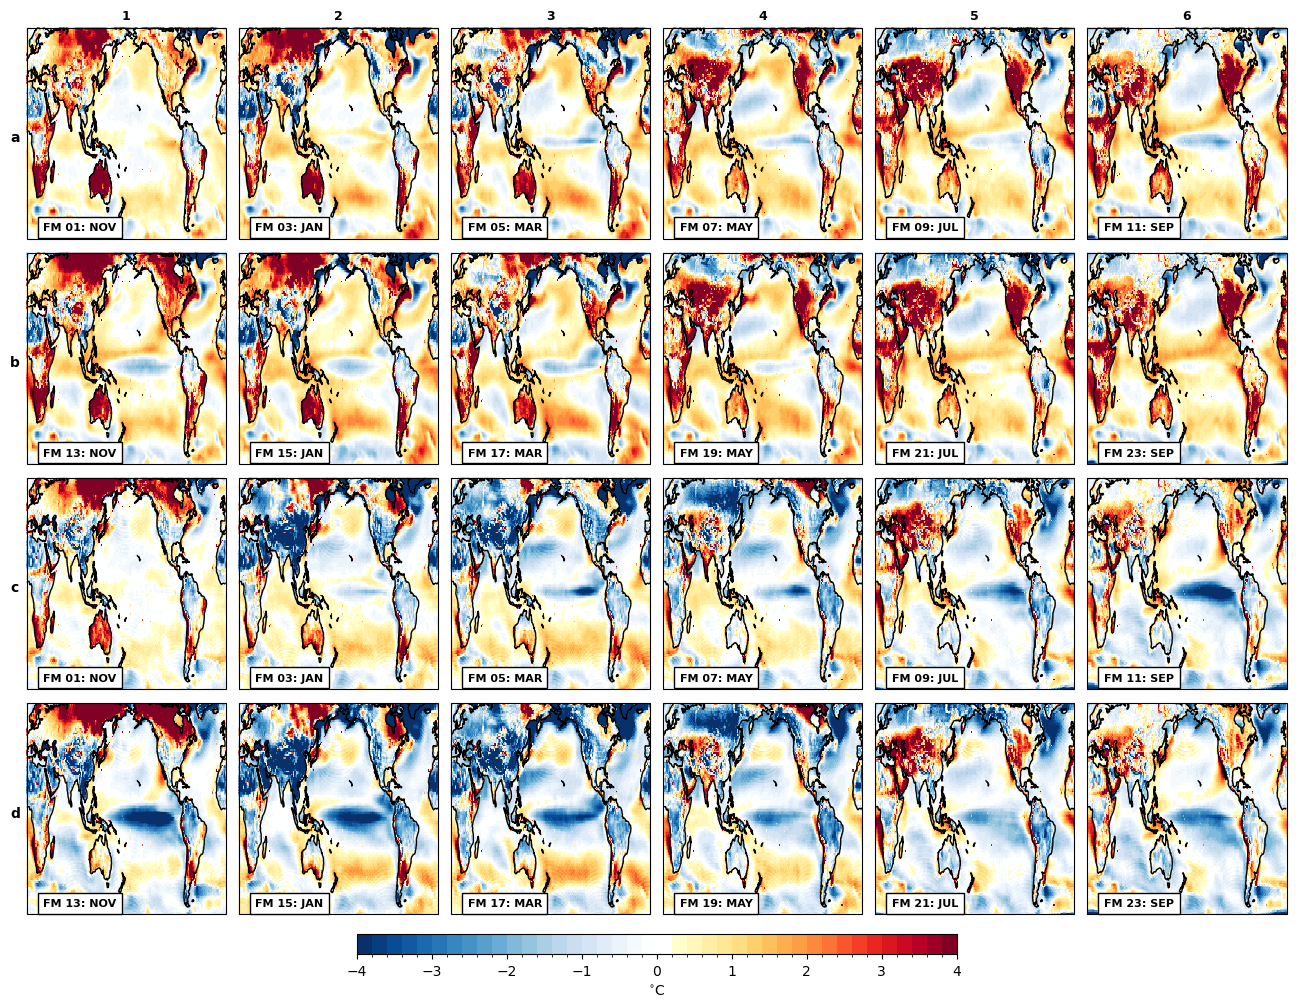

In [58]:
%%time
ci = 0.2
cmin = -4
cmax = 4

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, cesm_climobias2.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, e3sm_climobias2.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig06.png')

## Figure 7

In [59]:
%%time
cesm_climodiff2_1mem = (cesm_climobias2_1mem - cesm_climobias2).std('iteration').load()
e3sm_climodiff2_1mem = (e3sm_climobias2_1mem - e3sm_climobias2).std('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.35 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.48 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 26.3 s, sys: 1.14 s, total: 27.4 s
Wall time: 56.4 s


CPU times: user 35.1 s, sys: 200 ms, total: 35.3 s
Wall time: 37.4 s


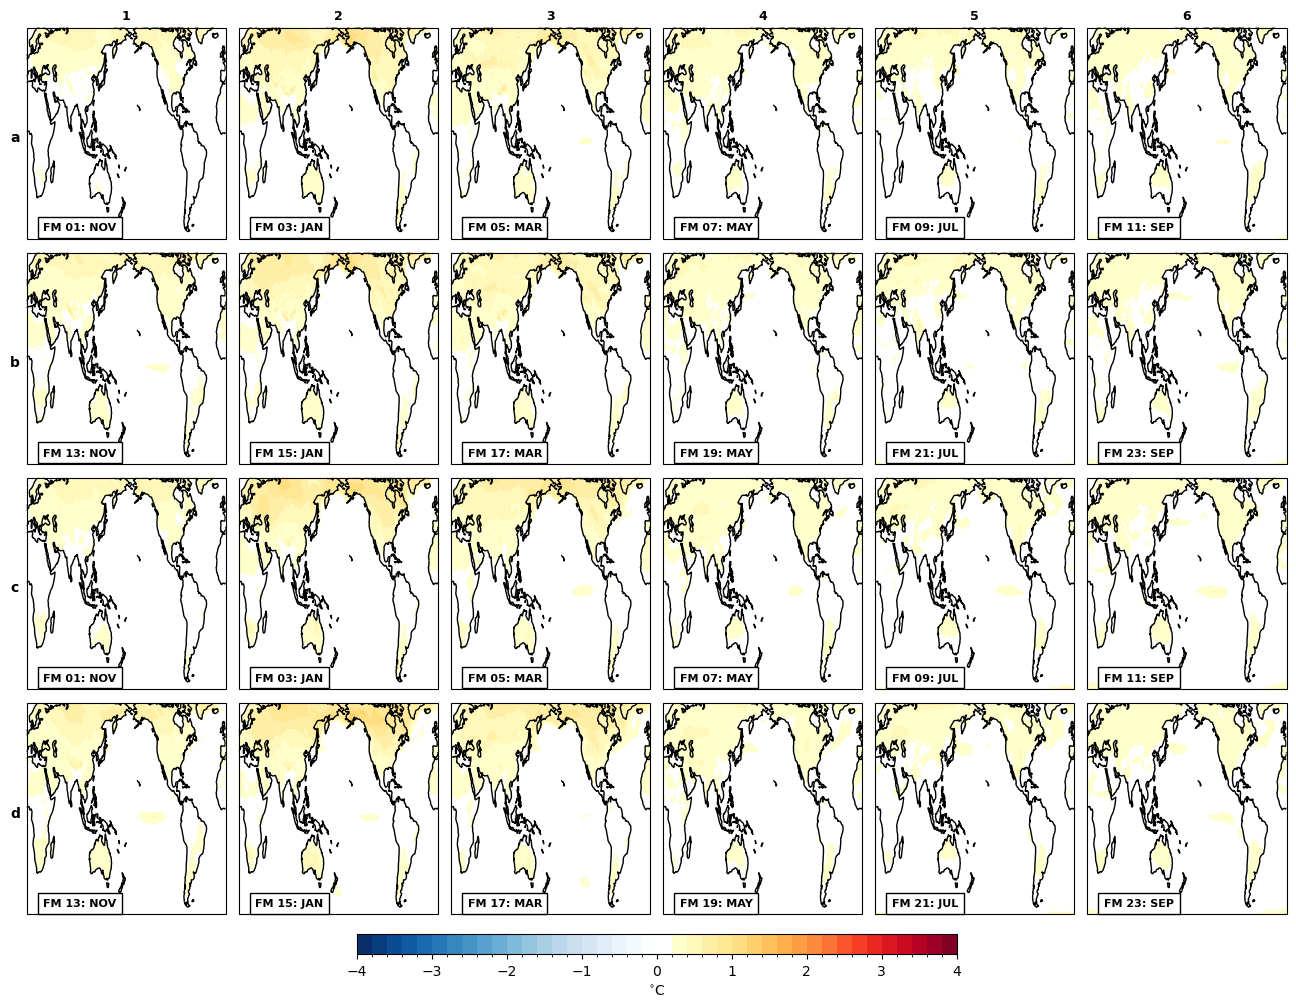

In [60]:
%%time
ci = 0.2
cmin = -4
cmax = 4

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_climodiff2_1mem
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_climodiff2_1mem
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig07.png')

## Supplementary Figure 4

In [61]:
%%time
cesm_climodiff2_3mem = (cesm_climobias2_3mem - cesm_climobias2).std('iteration').load()
e3sm_climodiff2_3mem = (e3sm_climobias2_3mem - e3sm_climobias2).std('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.18 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 19.30 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 54.8 s, sys: 1.73 s, total: 56.6 s
Wall time: 1min 6s


CPU times: user 37.9 s, sys: 154 ms, total: 38 s
Wall time: 40.8 s


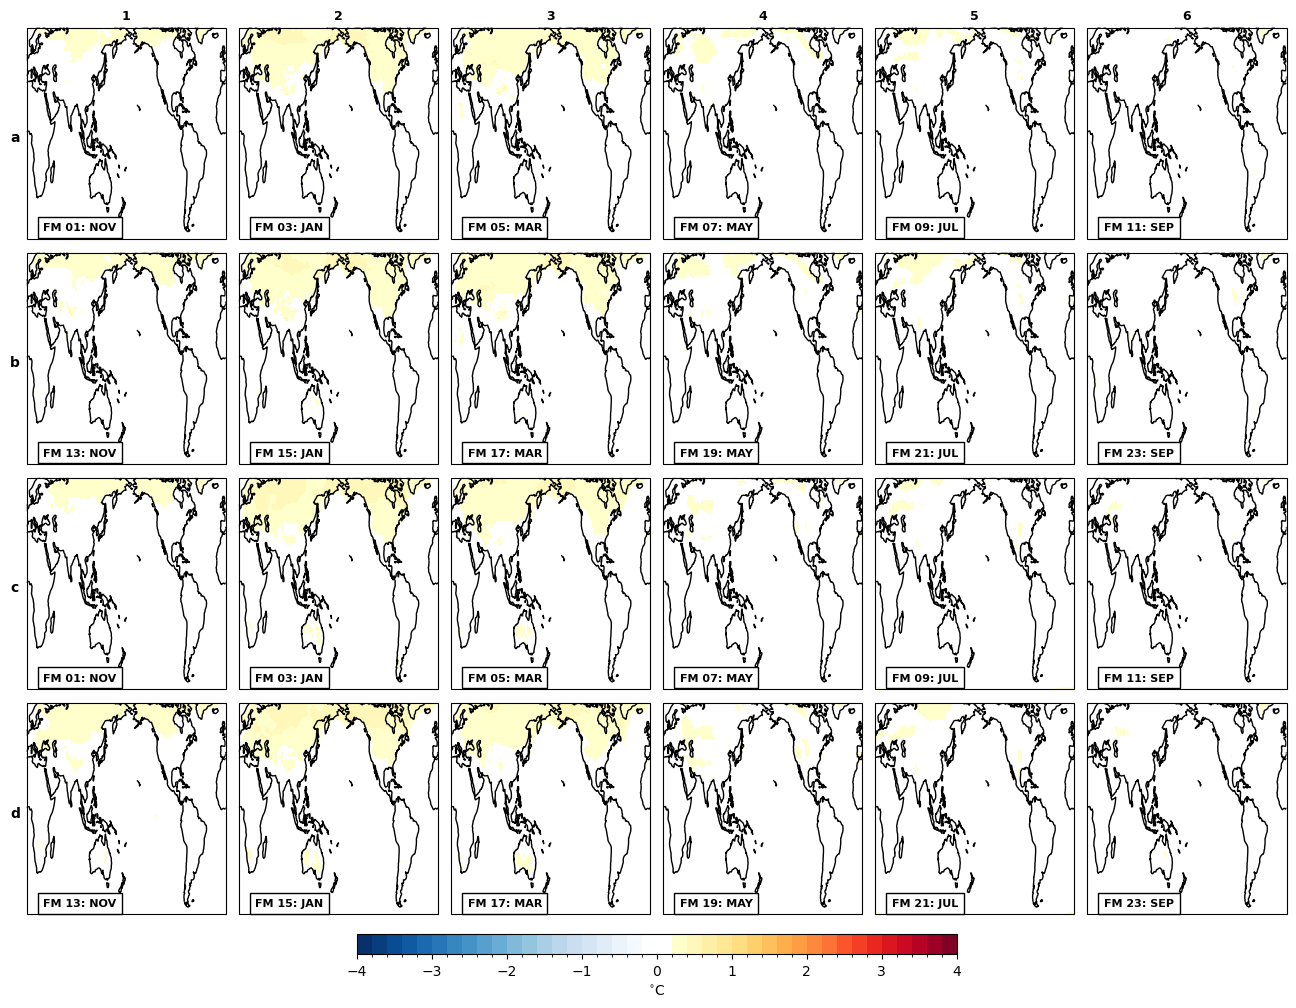

In [62]:
%%time
ci = 0.2
cmin = -4
cmax = 4

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_climodiff2_3mem
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_climodiff2_3mem
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig_supp04.png')

## Supplementary Figure 5

CPU times: user 35.2 s, sys: 182 ms, total: 35.3 s
Wall time: 38.1 s


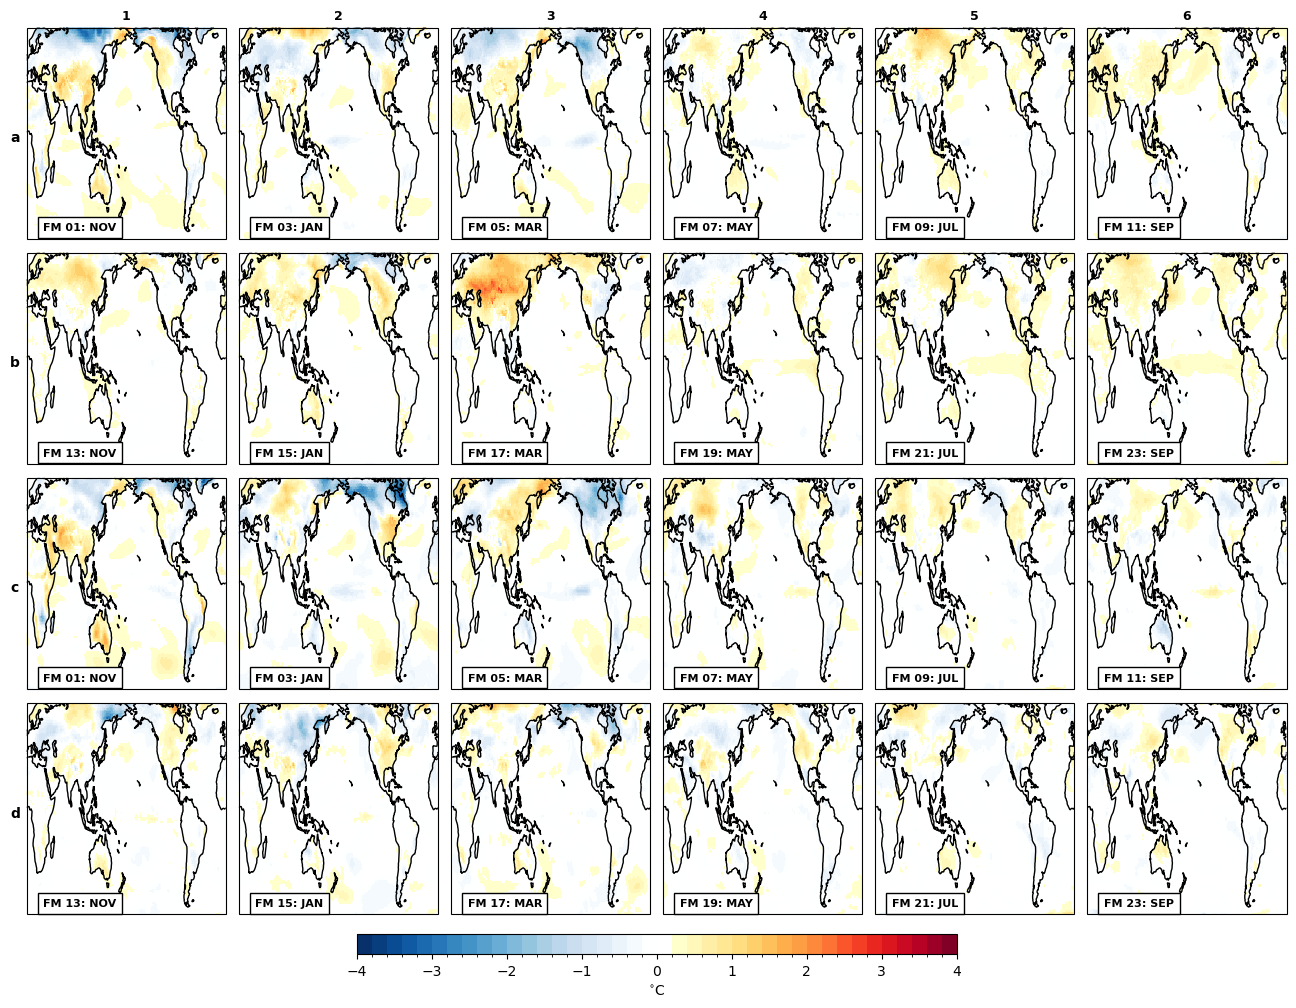

In [63]:
%%time
ci = 0.2
cmin = -4
cmax = 4

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_climobias3 - cesm_climobias2
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        #ax1.set_ylabel('a',fontsize=9,weight='bold')
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_climobias3 - e3sm_climobias2
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = 'FM '+str(iind+1).zfill(2)+': '+mondict[thismon]
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0):
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    #ax1.set_title(leadstr,loc='center',fontsize=9)
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08,left=0.15)
cbar_ax = fig.add_axes([0.37, 0.04, 0.4, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'$^{\circ}$C', orientation='horizontal')

plt.savefig('Fig_supp05.png')

In [64]:
%%time
cesm_msss3 = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth3,cesm_smyle11_anom_meth2,nleads=23,resamp=0,detrend=False)
cesm_msss3 = cesm_msss3.load()

CPU times: user 4.57 s, sys: 290 ms, total: 4.86 s
Wall time: 12.7 s


In [65]:
%%time
cesm_msss1 = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth1,cesm_smyle11_anom_meth2,nleads=23,resamp=0,detrend=False)
cesm_msss1 = cesm_msss1.load()

CPU times: user 6.36 s, sys: 461 ms, total: 6.83 s
Wall time: 25.6 s


In [66]:
%%time
chunks = {'M':1,'Y':-1}
cesm_msss2_1mem = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth2_1mem.chunk(chunks),cesm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False)
cesm_msss2_1mem = cesm_msss2_1mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 15.42 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 30s, sys: 10.4 s, total: 3min 40s
Wall time: 4min 31s


In [67]:
%%time
chunks = {'M':1,'Y':-1}
cesm_msss2_3mem = stat.compute_skillcompare_monthly(cesm_smyle11_anom_meth2_3mem.chunk(chunks),cesm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False)
cesm_msss2_3mem = cesm_msss2_3mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 22.26 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 3min 38s, sys: 7.9 s, total: 3min 46s
Wall time: 5min 13s


In [68]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss1 = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth1.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss1 = e3sm_msss1.load()

CPU times: user 25.8 s, sys: 2.39 s, total: 28.2 s
Wall time: 2min 38s


In [69]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss3 = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth3.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss3 = e3sm_msss3.load()

CPU times: user 11.9 s, sys: 1.05 s, total: 12.9 s
Wall time: 51.6 s


In [70]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss2_1mem = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth2_1mem.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss2_1mem = e3sm_msss2_1mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 20.07 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 4min 2s, sys: 8.55 s, total: 4min 11s
Wall time: 5min 32s


In [71]:
%%time
chunks = {'M':1,'Y':-1}
e3sm_msss2_3mem = stat.compute_skillcompare_monthly(e3sm_smyle11_anom_meth2_3mem.chunk(chunks),e3sm_smyle11_anom_meth2.chunk(chunks),nleads=23,resamp=0,detrend=False,usedask=False)
e3sm_msss2_3mem = e3sm_msss2_3mem.mean('iteration').load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 26.89 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 4min 4s, sys: 8.19 s, total: 4min 13s
Wall time: 5min 11s


## Figure 8

CPU times: user 51.2 s, sys: 318 ms, total: 51.5 s
Wall time: 55 s


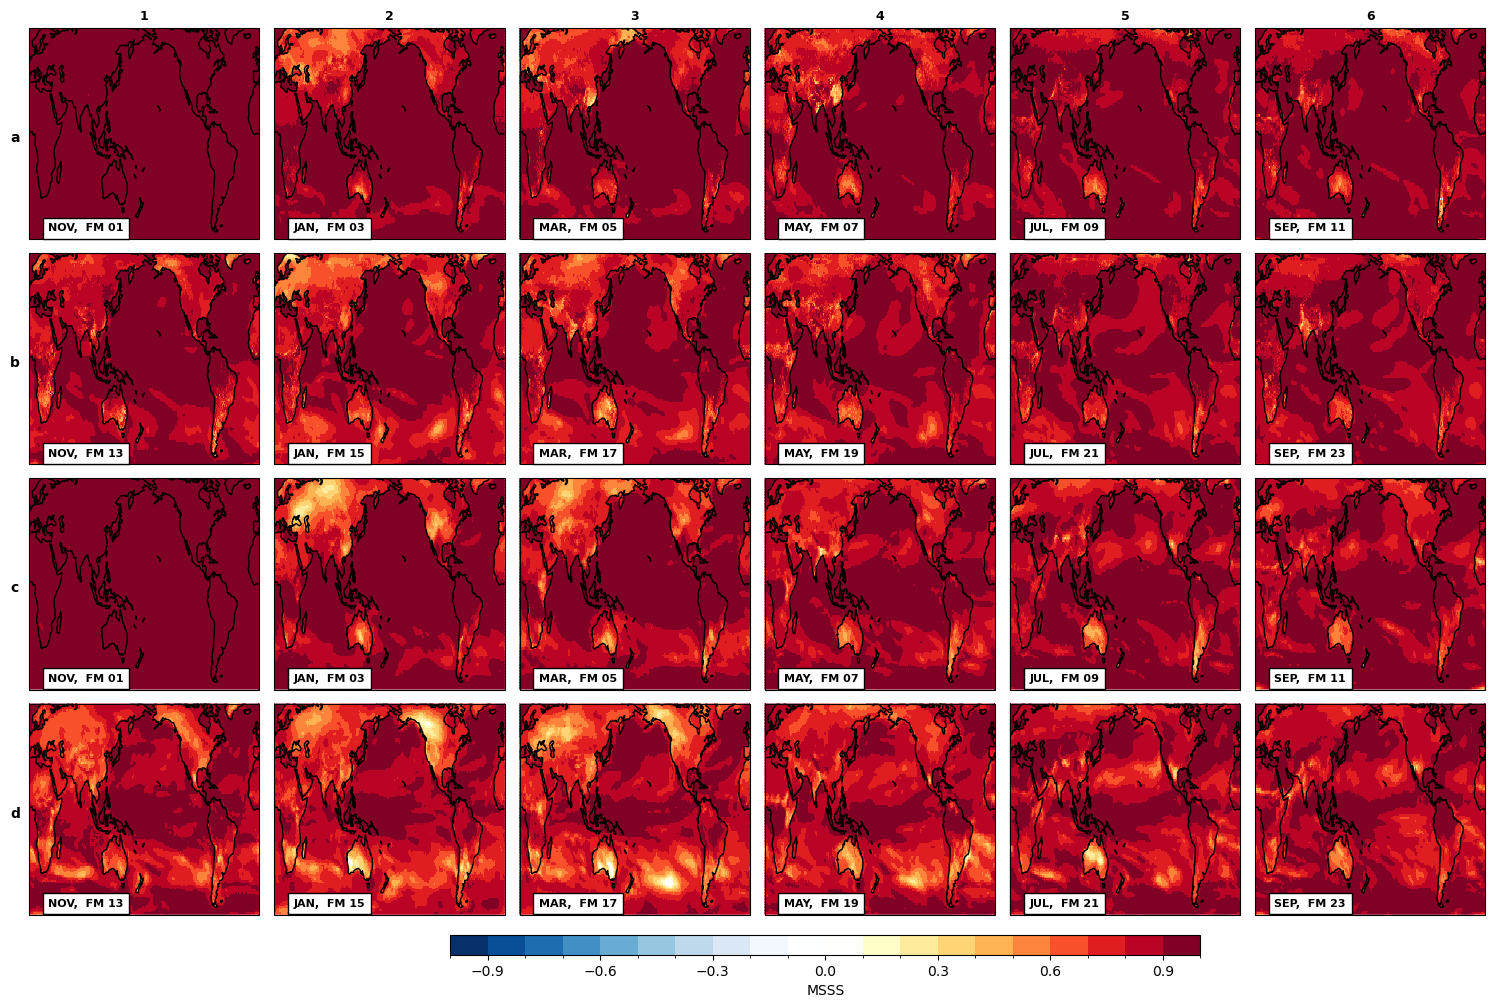

In [72]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss2_1mem['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss2_1mem['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig08.png')

## Supplementary Figure 6

CPU times: user 35.9 s, sys: 466 ms, total: 36.4 s
Wall time: 39.2 s


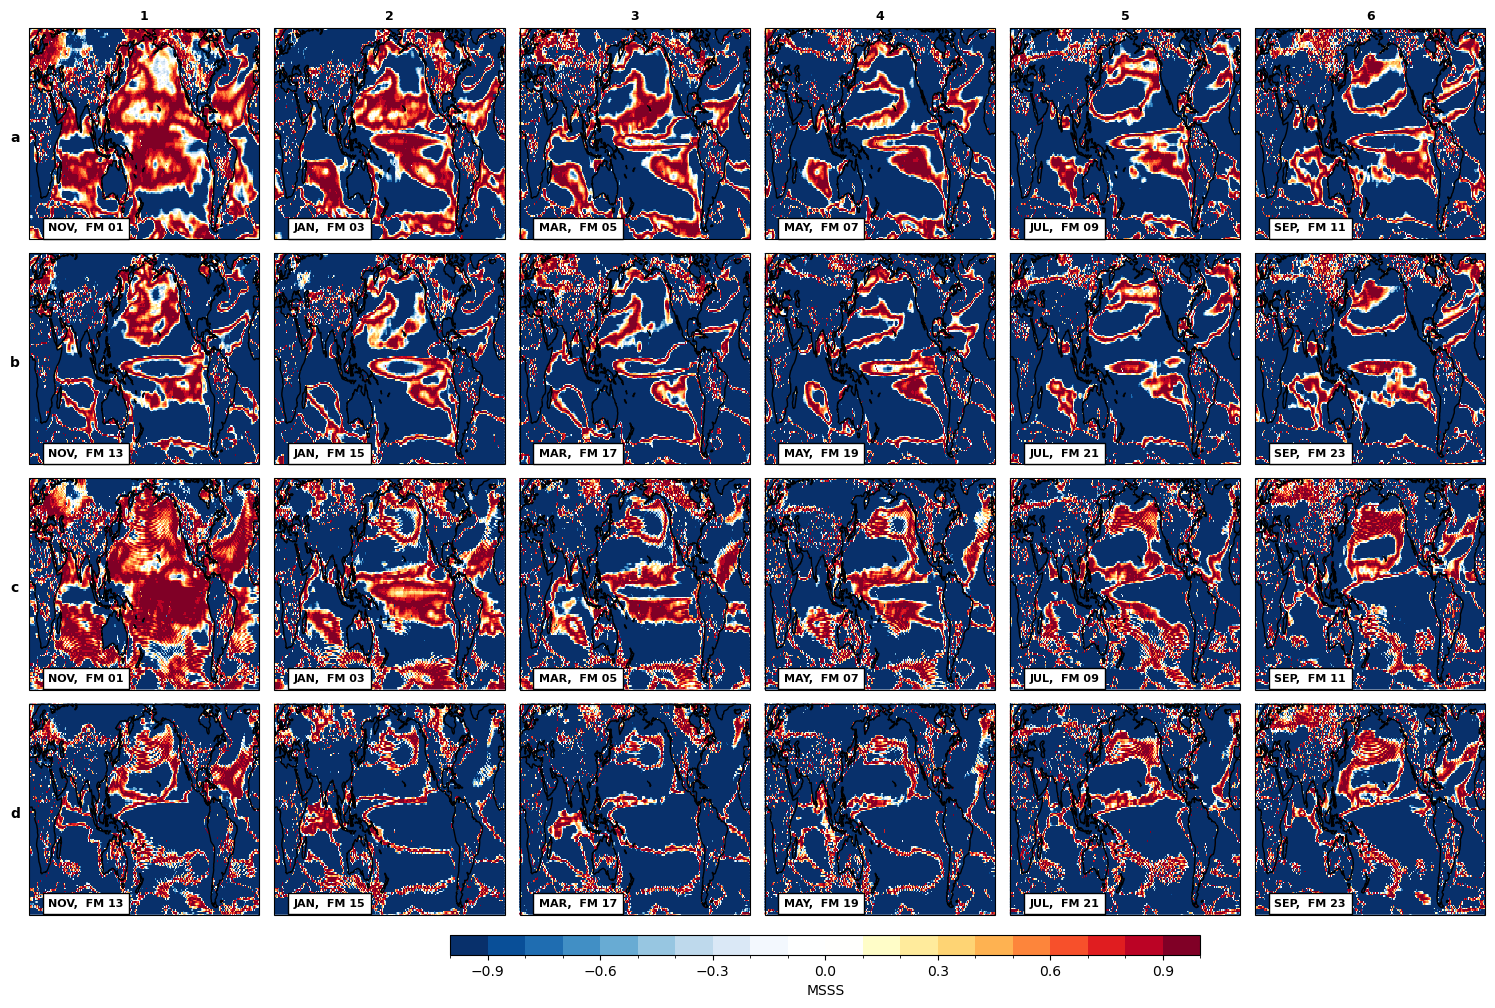

In [73]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss1['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss1['msss']
for i in range(12):
    iind = i*2
    thismon = cesm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp06.png')

## Supplementary Figure 7

CPU times: user 50.8 s, sys: 528 ms, total: 51.3 s
Wall time: 55.6 s


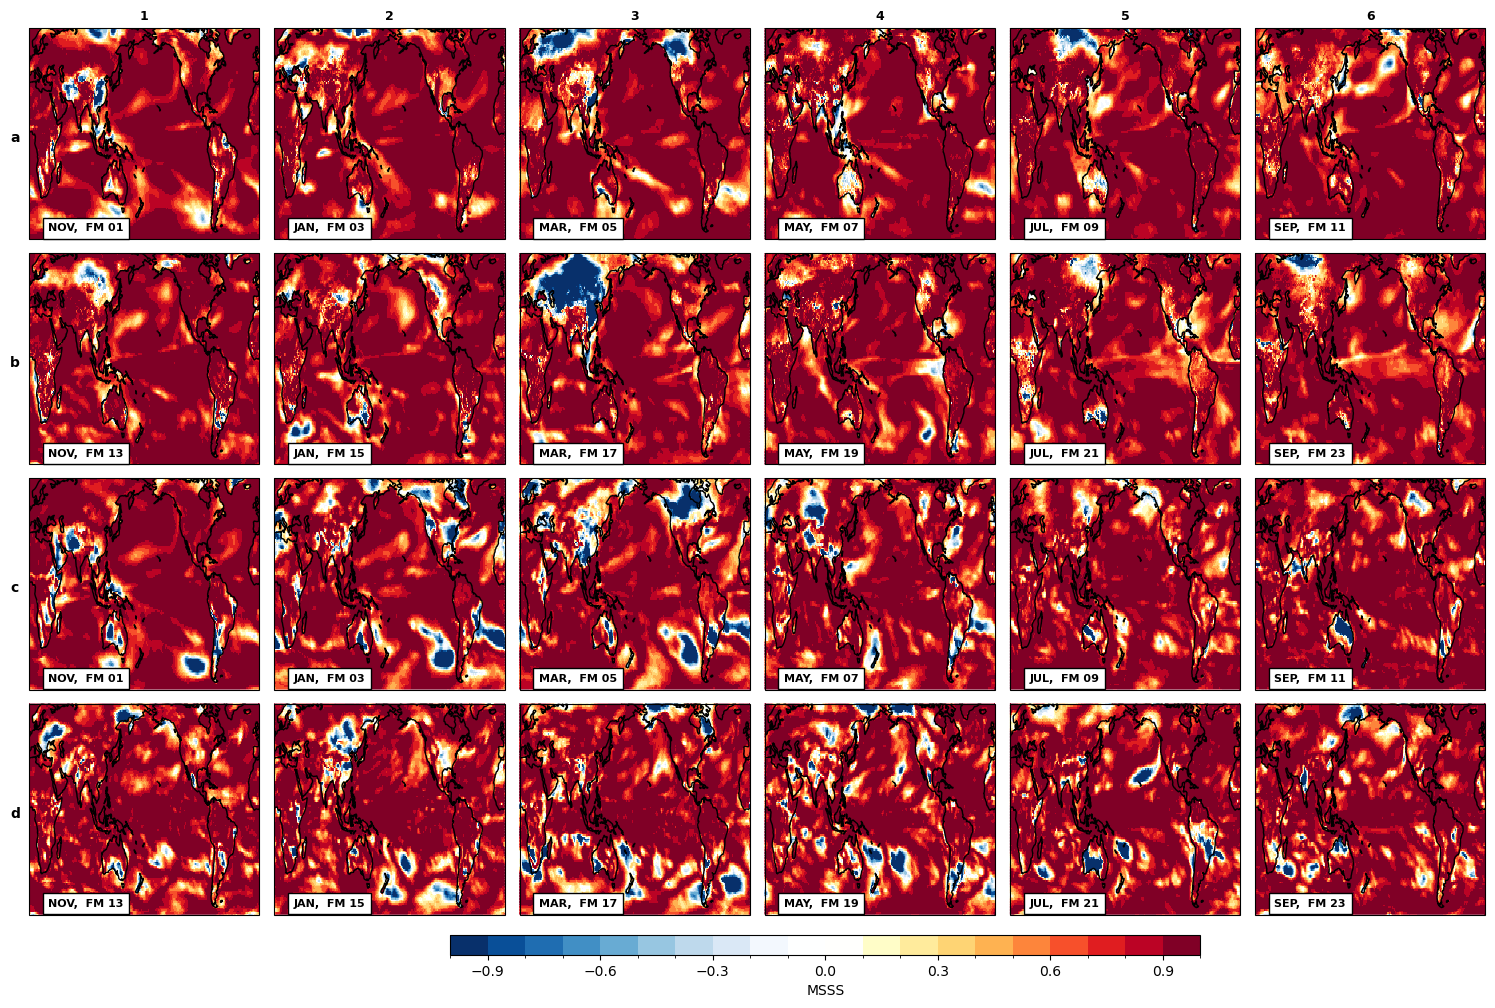

In [74]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss3['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss3['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp07.png')

## Supplementary Figure 8

CPU times: user 50.8 s, sys: 454 ms, total: 51.3 s
Wall time: 55.8 s


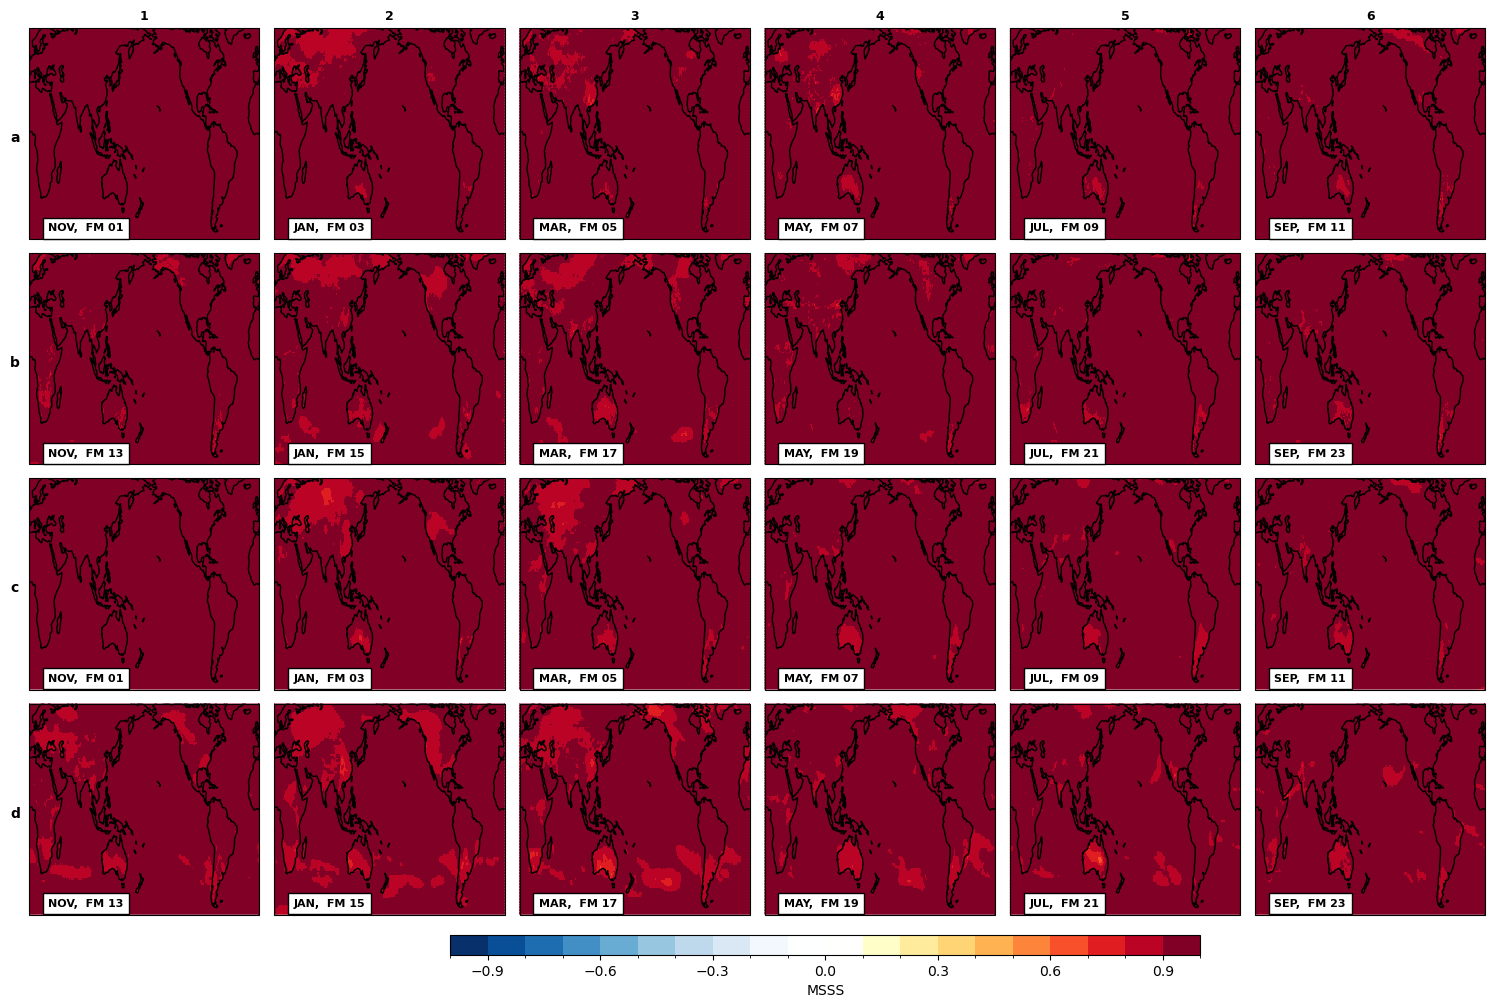

In [75]:
%%time
ci = 0.1
cmin = -1
cmax = 1

fig = plt.figure(figsize=(15,10))
nrows=4
ncols=6

proj = ccrs.PlateCarree(central_longitude=180)

mondict = {1:'JAN',2:'FEB',3:'MAR',4:'APR',5:'MAY',6:'JUN',7:'JUL',8:'AUG',9:'SEP',10:'OCT',11:'NOV',12:'DEC'}

fsize=10
fweight='bold'
cmap = "blue2red"

tmp = cesm_msss2_3mem['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+1,proj,grid='latlon',cmap=cmap)
    if (i<6):
        ax1.set_title(str(i+1),loc='center',fontsize=9,weight='bold')
    if (i == 0): 
        ax1.text(-210,0,'a',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'b',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])

tmp = e3sm_msss2_3mem['msss']
for i in range(12):
    iind = i*2
    thismon = e3sm_smyle11_time.isel(Y=0).isel(L=iind).dt.month.values.tolist()
    leadstr = mondict[thismon]+',  FM '+str(iind+1).zfill(2)
    labstr = 'b'+str(i+1).zfill(2)
    ax1,cntr1 = maps.map_pcolor_global_subplot(fig, tmp.isel(L=iind), lon, lat,ci,cmin,cmax,'',nrows,ncols,i+13,proj,grid='latlon',cmap=cmap)
    if (i == 0): 
        ax1.text(-210,0,'c',fontsize=10,weight='bold')
    if (i == 6): 
        ax1.text(-210,0,'d',fontsize=10,weight='bold')
    #ax1.set_title(labstr,loc='left',fontsize=9,weight='bold')
    ax1.text(-150.,-55,leadstr,fontsize=8,fontweight=fweight,bbox=dict(facecolor='white', edgecolor='black'))
    ax1.set_ylim([-60,70])


fig.tight_layout()
fig.subplots_adjust(bottom=0.08)
cbar_ax = fig.add_axes([0.3, 0.04, 0.5, 0.02])
fig.colorbar(cntr1, cax=cbar_ax, label=r'MSSS', orientation='horizontal')

plt.savefig('Fig_supp08.png')

## Regional SST

In [76]:
def reg_avg(ds,wgt,region):
    tmp_ds = ds.sel(lon=slice(region[0],region[1])).sel(lat=slice(region[2],region[3]))
    tmp_wgt = wgt.sel(lat=slice(region[2],region[3]))
    ds_out = tmp_ds.weighted(tmp_wgt).mean(['lat','lon'])
    return ds_out

In [77]:
coswgts = np.cos(np.deg2rad(lat))

In [78]:
reglonlat = [360-170.,360-120.,-5.,5.]

In [79]:
chunks = {'M':20}

In [80]:
%%time
cesm_nino34_meth1 = reg_avg(cesm_smyle11_anom_meth1.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 2.57 s, sys: 208 ms, total: 2.78 s
Wall time: 25 s


In [81]:
%%time
cesm_nino34_meth2 = reg_avg(cesm_smyle11_anom_meth2.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 2.77 s, sys: 300 ms, total: 3.07 s
Wall time: 23.6 s


In [82]:
%%time
cesm_nino34_meth2_1mem = reg_avg(cesm_smyle11_anom_meth2_1mem.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 15.4 s, sys: 935 ms, total: 16.3 s
Wall time: 29.4 s


In [83]:
%%time
cesm_nino34_meth2_3mem = reg_avg(cesm_smyle11_anom_meth2_3mem.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 37.4 s, sys: 1.44 s, total: 38.9 s
Wall time: 54.5 s


In [84]:
%%time
cesm_nino34_meth3 = reg_avg(cesm_smyle11_anom_meth3.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 3.17 s, sys: 249 ms, total: 3.42 s
Wall time: 23.1 s


In [85]:
%%time
e3sm_nino34_meth1 = reg_avg(e3sm_smyle11_anom_meth1.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 4.71 s, sys: 400 ms, total: 5.11 s
Wall time: 26.3 s


In [86]:
%%time
e3sm_nino34_meth2 = reg_avg(e3sm_smyle11_anom_meth2.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 6.43 s, sys: 488 ms, total: 6.92 s
Wall time: 31.4 s


In [87]:
%%time
e3sm_nino34_meth2_1mem = reg_avg(e3sm_smyle11_anom_meth2_1mem.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 1min 16s, sys: 1.58 s, total: 1min 18s
Wall time: 1min 28s


In [88]:
%%time
e3sm_nino34_meth2_3mem = reg_avg(e3sm_smyle11_anom_meth2_3mem.chunk(chunks),coswgts,reglonlat).load()

/glade/work/yeager/conda-envs/mypythonenv5/lib/python3.13/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 15.55 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CPU times: user 1min 42s, sys: 1.98 s, total: 1min 44s
Wall time: 2min 1s


In [89]:
%%time
e3sm_nino34_meth3 = reg_avg(e3sm_smyle11_anom_meth3.chunk(chunks),coswgts,reglonlat).load()

CPU times: user 6.31 s, sys: 368 ms, total: 6.68 s
Wall time: 27.8 s


In [90]:
obs_nino34 = reg_avg(obs_mon_anom,coswgts,reglonlat)

## Figure 9

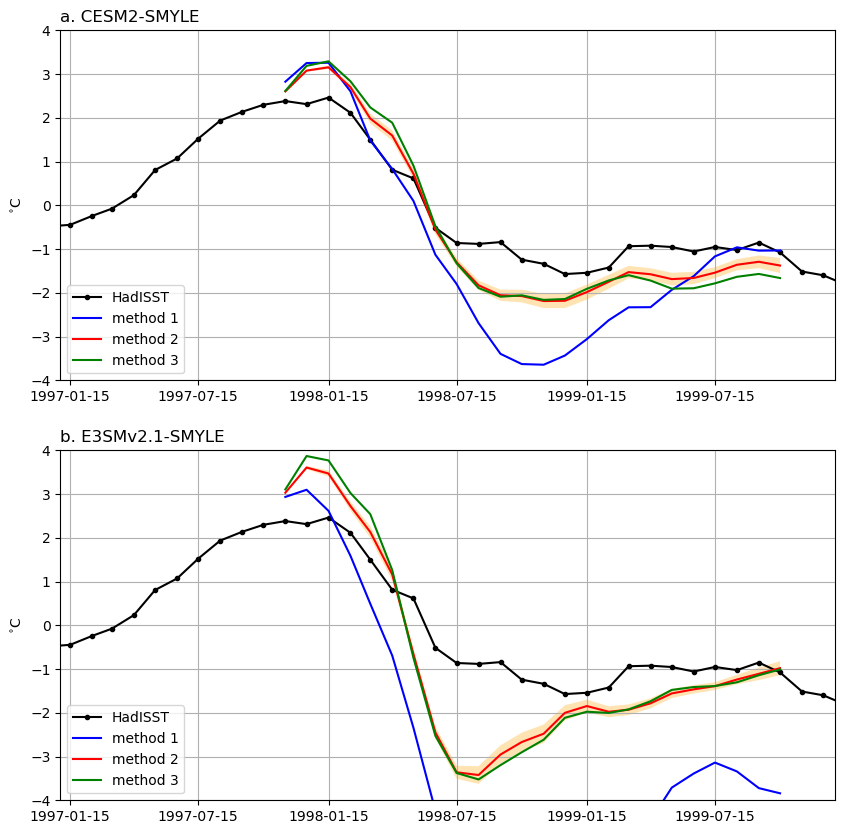

In [93]:
import datetime
import cftime
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

thisyear = 1997
#smyletime = cesm_smyle11_time.sel(Y=thisyear)
smyletime = [cftime.datetime(d.dt.year,d.dt.month,d.dt.day) for d in cesm_smyle11_time.sel(Y=thisyear)]
xtickyears = [1960,1965,1975,1985,1995,2005,2015]
xticks = [cftime.num2date(0, 'days since {}-{}-15 00:00:00'.format(i,j), calendar='noleap') for i in np.arange(thisyear,thisyear+3) for j in [1,7]]
xmin = cftime.num2date(0, 'days since {}-01-01 00:00:00'.format(thisyear), calendar='noleap')
xmax = cftime.num2date(0, 'days since {}-01-01 00:00:00'.format(thisyear+3), calendar='noleap')

tmp = cesm_nino34_meth2.sel(Y=thisyear).mean('M')
tmp_sd1 = cesm_nino34_meth2_1mem.sel(Y=thisyear).mean('M').std('iteration')
low = tmp-tmp_sd1
high = tmp+tmp_sd1
ax1.fill_between(smyletime,low,high,fc='orange',alpha=0.3)
ax1.plot(obs_nino34.time,obs_nino34['TS'],color='k',marker='.',label='HadISST')
ax1.plot(smyletime,cesm_nino34_meth1.sel(Y=thisyear).mean('M'),color='b',label='method 1')
ax1.plot(smyletime,tmp,color='r',label='method 2')
ax1.plot(smyletime,cesm_nino34_meth3.sel(Y=thisyear).mean('M'),color='g',label='method 3')
ax1.set_ylabel(r'$^{\circ}$C')
ax1.set_ylim(-4,4)
ax1.set_xticks(xticks)
ax1.set_xlim(xmin,xmax)
ax1.legend(loc='lower left')
ax1.set_title('a. CESM2-SMYLE',loc='left')
#ax1.set_title('Monthly Nino-3.4 SST',loc='center')
ax1.grid()

smyletime = [cftime.datetime(d.dt.year,d.dt.month,d.dt.day) for d in e3sm_smyle11_time.sel(Y=thisyear)]
tmp = e3sm_nino34_meth2.sel(Y=thisyear).mean('M')
tmp_sd1 = e3sm_nino34_meth2_1mem.sel(Y=thisyear).mean('M').std('iteration')
low = tmp-tmp_sd1
high = tmp+tmp_sd1
ax2.fill_between(smyletime,low,high,fc='orange',alpha=0.3)
ax2.plot(obs_nino34.time,obs_nino34['TS'],color='k',marker='.',label='HadISST')
ax2.plot(smyletime,e3sm_nino34_meth1.sel(Y=thisyear).mean('M'),color='b',label='method 1')
ax2.plot(smyletime,tmp,color='r',label='method 2')
ax2.plot(smyletime,e3sm_nino34_meth3.sel(Y=thisyear).mean('M'),color='g',label='method 3')
#ax2.plot(smyletime,e3sm_nino34_meth1.sel(Y=thisyear).mean('M'),color='b',label='meth1')
#ax2.plot(smyletime,e3sm_nino34_meth3.sel(Y=thisyear).mean('M'),color='cyan',label='meth3')
#ax2.plot(smyletime,e3sm_nino34_meth2_1mem.sel(Y=thisyear).mean('M').mean('iteration'),color='g',linestyle='--',label='meth2 (1-mem)')
#ax2.plot(smyletime,e3sm_nino34_meth2_3mem.sel(Y=thisyear).mean('M').mean('iteration'),color='orange',linestyle='--',label='meth2 (3-mem)')
#ax2.plot(smyletime,e3sm_nino34_meth2.sel(Y=thisyear).mean('M'),color='r',label='meth2 (20-mem)')
ax2.set_ylabel(r'$^{\circ}$C')
ax2.set_ylim(-4,4)
ax2.set_xticks(xticks)
ax2.set_xlim(xmin,xmax)
ax2.legend(loc='lower left')
ax2.set_title('b. E3SMv2.1-SMYLE',loc='left')
#ax2.set_title('Monthly Nino-3.4 SST',loc='center')
ax2.grid()

plt.savefig('Fig09.png')